# MNIST — Dataset of Handwritten Digits
MNIST is a widely used dataset of handwritten digits that contains 60,000 handwritten digits for training a machine learning model and 10,000 handwritten digits for testing the model. It is also called the “Hello, World” dataset as it’s very easy to use. The dataset contains 70,000 grayscale 28x28 pixel images of handwritten digits between 0 and 9.


## A GAN operates in the following steps in case of generating images.

1. The generator takes in random numbers (noise) and returns an image.
2. This generated image is fed into the discriminator with images taken from the ground-truth dataset.
3. The discriminator takes in both real and fake images and returns probabilities.
4. In a train process, the generator tries to generate synthetic images to deceive the discriminator while the discriminator tries to predict whether the image is real or fake.

Through this series of processes, we can obtain images that are close to the real images.

# GAN

In [ ]:
# Import Libraries
import tensorflow as tf
import numpy as np
import random

import matplotlib.pyplot as pyplot
import keras
from keras import layers
#from keras import ops

import warnings
warnings.filterwarnings("ignore", message=".*Compiled the loaded model.*")

In [ ]:
# Data Load Process
import tensorflow
from tensorflow.keras.datasets.mnist import load_data
(X_train, y_train), (X_test, y_test) = load_data()

In [ ]:
# Summarize the shape of the daatset
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [ ]:
X = np.concatenate((X_train, X_test))

print(X.shape)

(70000, 28, 28)


In [ ]:
Y = np.bincount(X[0,:,:].flatten())
print(Y)

[618   2   3   1   0   0   0   0   0   1   0   3   0   0   1   0   2   0
   5   0   0   0   0   1   1   1   1   1   0   0   1   0   0   0   0   1
   1   0   0   2   0   0   0   1   0   1   1   0   0   1   0   0   0   0
   0   1   1   0   0   0   0   0   0   0   2   0   1   0   0   0   1   0
   0   0   0   0   0   0   1   0   2   2   2   0   0   0   0   0   0   0
   1   0   0   2   1   0   0   0   0   0   0   0   0   0   0   0   0   1
   1   0   0   0   0   0   1   0   0   0   0   1   0   0   0   0   0   0
   1   1   0   0   1   0   1   1   0   1   2   0   0   1   0   0   0   0
   0   0   0   0   1   0   1   0   0   0   3   0   1   0   0   0   1   0
   0   0   0   0   1   0   0   0   1   1   2   0   0   1   0   0   0   0
   0   0   2   1   0   0   1   1   0   0   2   0   0   0   0   2   0   0
   2   0   0   1   0   0   0   1   0   1   0   0   0   0   1   1   0   0
   0   0   0   2   0   1   0   0   0   2   1   0   0   1   0   0   0   0
   0   0   0   0   1   0   1   2   1   0   1   0   

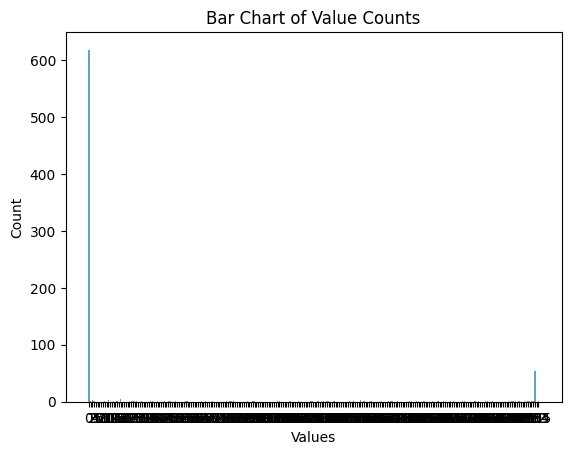

In [ ]:
Y = np.bincount(X[0,:,:].flatten())

# Plotting the bar chart
pyplot.bar(np.arange(len(Y)), Y, align='center', alpha=0.7)

# Adding labels and title

pyplot.xlabel('Values')
pyplot.ylabel('Count')
pyplot.title('Bar Chart of Value Counts')

# Adding x ticks with labels
pyplot.xticks(np.arange(len(Y)), np.arange(len(Y)))

# Display the plot
pyplot.show()

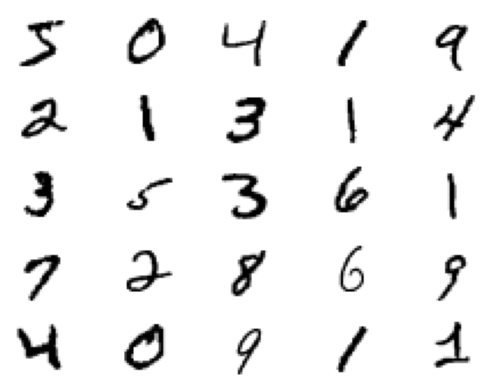

In [ ]:
# Visualize some of the images
for i in range(25):
  # define subplot
  pyplot.subplot(5,5, i+1)

  pyplot.axis('off')

  # plot images
  pyplot.imshow(X[i] , cmap='gray_r')


pyplot.show()

In [ ]:
# Discriminator model training
def load_real_samples(dataset_X):
  #X = np.expand_dims(dataset_X, axis=-1)
  #X = X.astype('float32')
  X = dataset_X/255.0
  X = X.reshape(-1, 28, 28, 1)
  return X

In [ ]:
X = load_real_samples(X)

In [ ]:
print(X.shape)

(70000, 28, 28, 1)


## Discriminator Model
The discriminator model must take an image from the dataset and detect whether it is a real or fake image.

In [ ]:
# define discriminator mode

def define_discriminator(input = (28,28,1)):
  model = keras.Sequential()
  model.add(layers.Conv2D(128, 3, strides=(2,2), padding='same', input_shape=input))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))

  model.add(layers.Conv2D(128, 3, strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [ ]:
model = define_discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0

In [ ]:
# define real samples
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0,dataset.shape[0],n_samples)

  # retrieve selected images
  X = dataset[ix]

  # generate class labels
  y =np.ones((n_samples,1))
  return X, y

In [ ]:
# generating fake images
# For generating fake images we can use random pixel values in the range of [0,1]
def generate_fake_samples(n_samples):
  X = np.random.rand(28*28*n_samples)

  X = X.reshape((n_samples, 28,28,1))

  y = np.zeros((n_samples,1))
  return X, y

In [ ]:
# train the discriminator model
def train_discrinator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch/2)

  for i in range(n_iter):
    # generate real samples
    real_X, real_y = generate_real_samples(dataset, half_batch)

    # train the discriminator on the real samples
    lossreal, accreal = model.train_on_batch(real_X, real_y)

    # generate fake samples
    fake_X, fake_y = generate_fake_samples(half_batch)

    # train the discriminator on the real samples
    lossfake, accfake = model.train_on_batch(fake_X, fake_y)

    print(i+1, accreal, accfake)



In [ ]:
# Training our discriminator model and printing out its accuracy for detecting real and fake images
model = define_discriminator()

dataset = load_real_samples(X_train)

train_discrinator(model, dataset)

## Generaor Model
The generator model takes a point from the latent space as input and outputs plausible image of handwritten digits. The latent space is a vector space of standard Gaussian distributed values. During training the generator model assign meaning to the latent points.

In [ ]:
# define the generator model
def define_generator(input):
  model = keras.Sequential()

  # foundations for 7 * 7 image
  model.add(layers.Dense(128 * 7 * 7, input_dim=input))
  model.add(layers.LeakyReLU(0.2))

  # reshpe the image
  model.add(layers.Reshape((7,7,128)))

  # upsample it to 14 * 14
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))

  # upsample it to 28 8 28
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))

  return model

In [ ]:
# latent dimension
latent_dim = 100

# generate a model
model = define_generator(latent_dim)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                           

In [ ]:
# generate latent space
def generate_latent_space(latent_dim, n_samples):
  # generate points in latent space
  X = np.random.randn(latent_dim * n_samples)

  # reshape into a batch of inputs for the network
  X = X.reshape(n_samples, latent_dim)

  return X

In [ ]:
# The points from the latent space can be used as inputs to the generator model to generate new samples
# use the generator to generate n fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
  X = generate_latent_space(latent_dim, n_samples)
  X_output = g_model.predict(X, verbose=0)

  y = np.zeros((n_samples, 1))

  return X_output, y

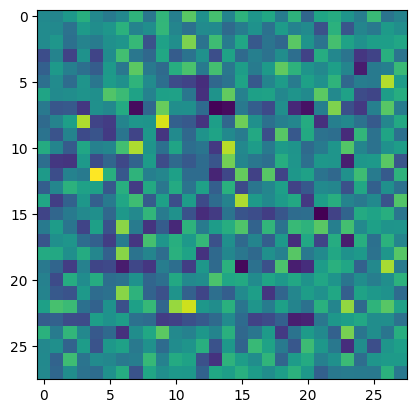

In [ ]:
# random generated image by generator
model = define_generator(latent_dim)

n_samples = 10

X , y = generate_fake_samples(model, latent_dim, n_samples)

for i in range(n_samples):
  pyplot.imshow(X[i,:,:,0])

## GAN Performance Evaluation
Evaluate the accuracy of discriminator model on real and fake images.
Generate images using generator model periodically.
Save the generator model.

In [ ]:
# create and save a plot of generated images

# plot 100 images as 10 x 10 grid

def save_plot(examples, epoch, n=10):
  for i in range(n*n):
    pyplot.subplot(n,n,i+1)

    pyplot.axis('off')

    pyplot.imshow(examples[i,:,:,0], cmap='gray_r')

  # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()



In [ ]:
# evaluate the discriminator, plot and save the generated image

def summerize_perf(epoch, gen_model, disc_model, dataset, latent_dim, n_samples= 100):
  real_X, real_y = generate_real_samples(dataset, n_samples)
  lossreal, accreal = disc_model.evaluate(real_X, real_y, verbose=0)

  fake_X, fake_y = generate_fake_samples(gen_model, latent_dim, n_samples)
  lossfake, accfake = disc_model.evaluate(fake_X, fake_y, verbose=0)

  #print(accreal, accfake)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (accreal*100, accfake*100))

  # save plot
  save_plot(fake_X, epoch)

  # save the generator model
  filename = 'generator_model_%03d.h5' % (epoch+1)
  gen_model.save(filename)



## Generator Model Training
When the discriminator model is relatively good at detecting fake samples then the generator model is updated more whereas when the discriminator model is poor at detecting fake samples, the weights of the generator model is updated less. A new GAN model can be defined which takes a random input, generate samples and provide it as input to the discriminator model and output of the discriminator model is used to update the weight of the generator model.

The discriminator can be trained on real and fake samples in a standalone manner whereas the generator gets updated according to the performance of the discriminator model on detecting fake samples. Therefore the discriminator which is part of the new GAN model is marked as not trainable. Also the generated samples from the generator model are marked as real so the discriminator would detect it as real or fake and give a probability using which during backpropagation process the weights of the generator model is updated to minimize the loss.

https://saifgazali.medium.com/deep-convolutional-gan-for-mnist-handwritten-digits-7e18496b3e3e

In [ ]:
# defining GAN model
def define_gan(generator, discriminator):
  # make the weights of the discriminator as non trainable
  discriminator.trainable = False
  model = keras.Sequential()
  model.add(generator)
  model.add(discriminator)

  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

  model.compile(loss='binary_crossentropy', optimizer=opt) #, metrics=['accuracy']

  return model


In [ ]:
# Define GAN model and plotting its summary

# size of the latent space
latent_space = 100

# crate the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the GAN
gan_model = define_gan(g_model, d_model)

# Summarize GAN model
gan_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 155137    
                                                                 
Total params: 1319426 (5.03 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 155137 (606.00 KB)
_________________________________________________________________


Model training would include first updating the discriminator model with real and fake samples, then the generator model in the composite model is updated.

In [ ]:
# Training standalone discriminator and generator in GAN

def train_GAN(gen_model, disc_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  half_batch = int(n_batch/2)

  batch_per_epoch = int(dataset.shape[0]/n_batch)

  # manually enumerate epochs

  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(batch_per_epoch):
      # generate random selected real samples
      real_X, real_y = generate_real_samples(dataset, half_batch)

      # generate fake samples
      fake_X, fake_y = generate_fake_samples(gen_model, latent_dim, half_batch)

      X, Y = np.vstack((real_X, fake_X)), np.vstack((real_y, fake_y))

      # train the discriminator
      #lossreal, accreal = disc_model.train_on_batch(real_X, real_y )
      #lossfake, accfake = disc_model.train_on_batch(fake_X, fake_y)
      d_loss, _ = disc_model.train_on_batch(X, Y)

      # train generator
      gen_X = generate_latent_space(latent_dim, n_batch)
      gen_y = np.ones((n_batch, 1))

      # update the generator via the discriminator's error
      loss = gan_model.train_on_batch(gen_X, gen_y)

    if (i+1)%10 == 0:
      summerize_perf(i, gen_model, disc_model, dataset, latent_dim, 100)

In [ ]:
# Training GAN model for 50 epochs

# size of the latent dim
latent_dim = 100

# define discriminator
discriminator = define_discriminator()

# define generator
generator = define_generator(latent_dim)

# define GAN
GAN = define_gan(generator, discriminator)

# load image data
data = X
# train gen
train_GAN(generator, discriminator, GAN, data, latent_dim)

>Accuracy real: 91%, fake: 40%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Accuracy real: 99%, fake: 18%


>Accuracy real: 83%, fake: 59%


>Accuracy real: 73%, fake: 63%


>Accuracy real: 87%, fake: 44%


>Accuracy real: 50%, fake: 66%


>Accuracy real: 25%, fake: 92%


>Accuracy real: 67%, fake: 61%


>Accuracy real: 16%, fake: 97%


>Accuracy real: 47%, fake: 90%


In [ ]:
model = keras.saving.load_model('/content/generator_model_010.h5')

latent_points = generate_latent_space(100, 25)

X = model.predict(latent_points, verbose=0)

save_plot(X,2,5)

In [ ]:
model2 = keras.saving.load_model('/content/generator_model_100.h5')

latent_points2 = generate_latent_space(100, 25)

X2 = model2.predict(latent_points2, verbose=0)

save_plot(X,100,5)

# Conditional GAN

In [ ]:
# Import Libraries
import tensorflow as tf
import numpy as np
import random

import matplotlib.pyplot as pyplot
import keras
from keras import layers
from keras.models import Model
#from keras import ops

import warnings
warnings.filterwarnings("ignore", message=".*Compiled the loaded model.*")

In [ ]:
# Data Load Process
import tensorflow
from tensorflow.keras.datasets.mnist import load_data
(X_train, y_train), (X_test, y_test) = load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# Summarize the shape of the daatset
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [ ]:
X = np.concatenate((X_train, X_test))
print(X.shape)

Y = np.concatenate((y_train,y_test))
print(Y.shape)

(70000, 28, 28)
(70000,)


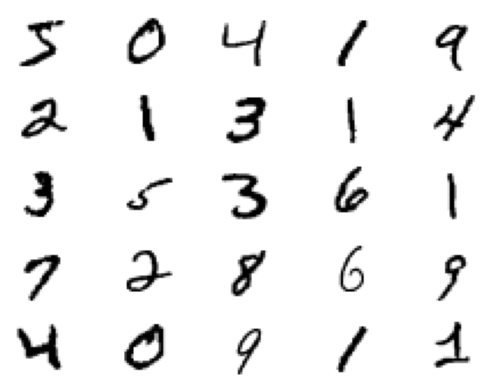

In [ ]:
# Visualize some of the images
for i in range(25):
  # define subplot
  pyplot.subplot(5,5, i+1)

  pyplot.axis('off')

  # plot images
  pyplot.imshow(X[i] , cmap='gray_r')


pyplot.show()

In [ ]:
# define standalone discriminator
def define_discriminator(input_shape=(28,28,1),n_classes=10):
  # label input
  in_labels = layers.Input(shape=(1,))
  # Embedding for categorical input
  em = layers.Embedding(n_classes,50)(in_labels)
  # scale up the image dimension with linear activations
  d1 = layers.Dense(input_shape[0] * input_shape[1])(em)
  # reshape to additional channel
  d1 = layers.Reshape((input_shape[0],input_shape[1],1))(d1)
  # image input
  image_input = layers.Input(shape=input_shape)
  #  concate label as channel
  merge = layers.Concatenate()([image_input,d1])
  # downsample
  fe = layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
  fe = layers.LeakyReLU(0.2)(fe)
  # downsample
  fe = layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
  fe = layers.LeakyReLU(0.2)(fe)
  #flatten feature maps
  fe = layers.Flatten()(fe)
  fe = layers.Dropout(0.4)(fe)
  #ouput
  out_layer = layers.Dense(1,activation='sigmoid')(fe)
  #define model
  model = Model([image_input,in_labels],out_layer)
  #compile model
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=  ['accuracy'])
  return model

In [ ]:
# define standalone generator model
def define_generator(latent_dim,n_classes=10):
  label_input = layers.Input(shape=(1,))
  #Embedding layer
  em = layers.Embedding(n_classes,50)(label_input)
  nodes = 7*7

  em = layers.Dense(nodes)(em)
  em = layers.Reshape((7,7,1))(em)
  #image generator input
  image_input = layers.Input(shape=(latent_dim,))
  nodes = 128*7*7
  d1 = layers.Dense(nodes)(image_input)
  d1 = layers.LeakyReLU(0.2)(d1)
  d1 = layers.Reshape((7,7,128))(d1)
  # merge
  merge = layers.Concatenate()([d1,em])
  #upsample to 14x14
  gen = layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(merge)
  gen = layers.LeakyReLU(0.2)(gen)
  #upsample to 28x28
  gen = layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(gen)
  gen = layers.LeakyReLU(0.2)(gen)
  #output layer
  out_layer = layers.Conv2D(1,(7,7),activation='tanh',padding='same')(gen)
  #define model
  model = Model([image_input,label_input],out_layer)
  return model

In [ ]:
# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model,d_model):
  # make the discriminator layer as non trainable
  d_model.trainable = False
  # get the noise and label input from the generator
  gen_noise, gen_label = g_model.input
  # get the output from the generator
  gen_output = g_model.output
  #connect image output and label input from generator as inputs to      #discriminator
  gan_output = d_model([gen_output,gen_label])
  #define gan model as taking noise and label and outputting a #classification
  model = Model([gen_noise,gen_label],gan_output)
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [ ]:
# Discriminator model training
def load_real_samples(dataset_X):
  #X = np.expand_dims(dataset_X, axis=-1)
  #X = X.astype('float32')
  X = dataset_X/255.0
  X = X.reshape(-1, 28, 28, 1)
  return X

In [ ]:
X = load_real_samples(X)

In [ ]:
# select real samples
def generate_real_samples(dataset,n_samples):
  # split into images and labels
  images,labels = dataset
  #choose random instances
  ix = np.random.randint(0,images.shape[0],n_samples)
  # select images and labels
  X, Labels = images[ix], labels[ix]
  # generate class labels
  y = np.ones((n_samples,1))
  return [X,Labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(laten_dim,n_samples,n_classes=10):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim*n_samples)
  # reshape into a batch of inputs to the network
  z_input = x_input.reshape(n_samples,latent_dim)
  # generate labels
  labels = np.random.randint(0,n_classes,n_samples)
  return [z_input,labels]

In [ ]:
# use generator to generate n fake samples, with class labels
def generate_fake_samples(latent_dim,n_samples,generator):
  #generate points in latent space
  z_input,labels = generate_latent_points(latent_dim,n_samples)
  #predict outputs
  images = generator.predict([z_input,labels], verbose=0)
  # create class labels
  y = np.zeros((n_samples,1))
  return [np.array(images),labels],y

In [ ]:
def train_gan(gen_model,disc_model,gan_model,latent_dim,dataset,n_epochs=100,n_batches=256):
  batches_per_epoch = int(dataset[0].shape[0]/n_batches)
  half_batch = int(n_batches/2)
  for i in range(n_epochs):
    print('epoch ',i)
    for j in range(batches_per_epoch):
      #generate real samples
      [X_real,labels_real], y_real = generate_real_samples(dataset,half_batch)
      #generate fake samples
      [X_fake,labels_fake], y_fake = generate_fake_samples(latent_dim,half_batch,gen_model)
      # train the discriminator on real and fake samples
      loss_real,acc_real = disc_model.train_on_batch([X_real,labels_real],y_real)
      loss_fake,acc_fake = disc_model.train_on_batch([X_fake,labels_fake],y_fake)
      # prepare points in the latent space as input to the generator
      [z_input,labels_input] = generate_latent_points(latent_dim,n_batches)
      # create inverted labels for fake samples
      y_gan = np.ones((n_batches,1))
      #update the generator model via the discriminator
      g_loss = gan_model.train_on_batch([z_input,labels_input],y_gan)
    if ((i+1)%10) == 0:
      gen_model.save('c_gan%3d.h5'%i)

In [ ]:
# size of the latent dimensions
latent_dim = 100
#discriminator model
discriminator = define_discriminator()
#generator model
generator = define_generator(latent_dim)
#create the gan model
gan = define_gan(generator,discriminator)
#dataset
dataset = [X,Y]
#train model
train_gan(generator,discriminator,gan,latent_dim,dataset)

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19


epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39


epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49


epoch  50
epoch  51
epoch  52
epoch  53
epoch  54
epoch  55
epoch  56
epoch  57
epoch  58
epoch  59


epoch  60
epoch  61
epoch  62
epoch  63
epoch  64
epoch  65
epoch  66
epoch  67
epoch  68
epoch  69


epoch  70
epoch  71
epoch  72
epoch  73
epoch  74
epoch  75
epoch  76
epoch  77
epoch  78
epoch  79


epoch  80
epoch  81
epoch  82
epoch  83
epoch  84
epoch  85
epoch  86
epoch  87
epoch  88
epoch  89


epoch  90
epoch  91
epoch  92
epoch  93
epoch  94
epoch  95
epoch  96
epoch  97
epoch  98
epoch  99


In [ ]:
def save_plot(X,n):
  for i in range(n*n):
    pyplot.axis('off')
    pyplot.subplot(n,n,i+1)
    pyplot.imshow(X[i,:,:,0],cmap='gray_r')
  pyplot.show()

4/4 [==============================] - 0s 71ms/step


<ipython-input-17-3f44635c3157>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(n,n,i+1)


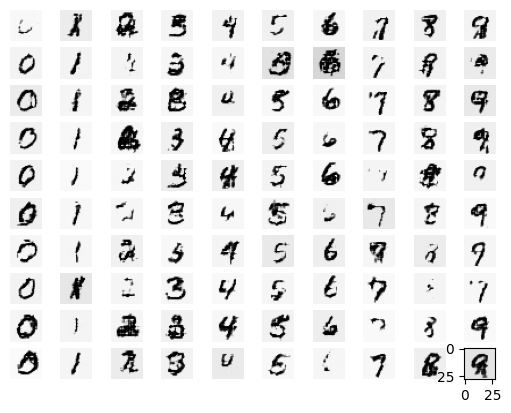

In [ ]:
model = keras.saving.load_model('/content/c_gan 99.h5')
# latent_dim
latent_dim = 100
[inputs,labels] = generate_latent_points(latent_dim,100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X = model.predict([inputs,labels])
save_plot(X,10)

4/4 [==============================] - 0s 5ms/step


<ipython-input-17-3f44635c3157>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(n,n,i+1)


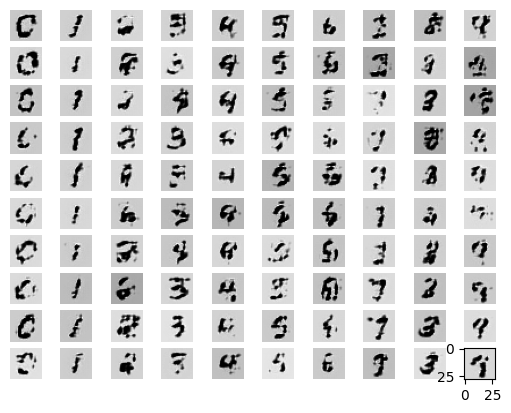

In [ ]:
model = keras.saving.load_model('/content/c_gan  9.h5')
# latent_dim
latent_dim = 100
[inputs,labels] = generate_latent_points(latent_dim,100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X = model.predict([inputs,labels])
save_plot(X,10)

4/4 [==============================] - 0s 7ms/step


<ipython-input-17-3f44635c3157>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(n,n,i+1)


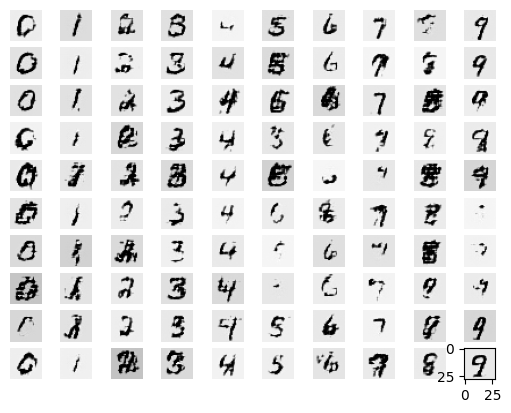

In [ ]:
model = keras.saving.load_model('/content/c_gan 59.h5')
# latent_dim
latent_dim = 100
[inputs,labels] = generate_latent_points(latent_dim,100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X = model.predict([inputs,labels])
save_plot(X,10)